In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Dropout,
    BatchNormalization, Activation,
    GlobalAveragePooling2D
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Import custom logger
sys.path.append('..')
from result_logger import log_result


# =========================================================
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)

# SYSTEM CHECK
print("TensorFlow Version:", tf.__version__)
# =========================================================

2026-02-02 15:51:14.939129: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-02 15:51:15.638325: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-02 15:51:32.194565: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPU Available: True
TensorFlow Version: 2.20.0


In [2]:
# =========================================================
# CONFIGURATION
# =========================================================
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 50

# Use raw Public_dataset (not preprocessed)
PUBLIC_DIR = "../Dataset/Public_dataset"
SELF_DIR = "../Dataset/SelfCollected_Dataset"

CLASS_NAMES = sorted(os.listdir(PUBLIC_DIR))
NUM_CLASSES = len(CLASS_NAMES)

# Create models directory
os.makedirs('models', exist_ok=True)

print("Classes:", CLASS_NAMES)


Classes: ['aluminium', 'paper', 'plastic']


In [3]:
# =========================================================
# DATA GENERATORS 
# =========================================================
# Training data generator with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Split 80% train, 20% validation
)

# Test data generator (no split needed)
test_datagen = ImageDataGenerator(
    rescale=1./255
)


In [4]:
# =========================================================
# LOAD DATA FROM DIRECTORIES
# =========================================================
# Training generator (80% of raw public dataset)
train_gen = train_datagen.flow_from_directory(
    PUBLIC_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    classes=CLASS_NAMES,
    subset='training'
)

# Validation generator (20% of raw public dataset)
val_gen = train_datagen.flow_from_directory(
    PUBLIC_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    classes=CLASS_NAMES,
    subset='validation'
)

# Test generator (self-collected dataset)
test_gen = test_datagen.flow_from_directory(
    SELF_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    classes=CLASS_NAMES
)

print("\n📊 Dataset Summary")
print("Train samples:", train_gen.samples)
print("Validation samples:", val_gen.samples)
print("Test samples (self):", test_gen.samples)


Found 2148 images belonging to 3 classes.
Found 536 images belonging to 3 classes.
Found 533 images belonging to 3 classes.

📊 Dataset Summary
Train samples: 2148
Validation samples: 536
Test samples (self): 533


In [5]:
# =========================================================
# CNN MODEL (MEMORY SAFE)
# =========================================================
model = Sequential([
    Conv2D(32, 3, padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(64, 3, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(128, 3, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

print("\n📋 Model Summary")
model.summary()


/mnt/c/laragon/www/CV-project/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1770018704.989078   45055 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6



📋 Model Summary


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,043 (433.76 KB)

 Trainable params: 110,595 (432.01 KB)

 Non-trainable params: 448 (1.75 KB)

In [6]:
# =========================================================
# CALLBACKS
# =========================================================
callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True),
    ReduceLROnPlateau(patience=4),
    ModelCheckpoint(
        'models/customvgg_testtrainraw.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [7]:
# =========================================================
# TRAINING
# =========================================================
print("\n🚀 Training started...\n")

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training complete!")


🚀 Training started...

Epoch 1/50


2026-02-02 15:51:48.950007: I external/local_xla/xla/service/service.cc:163] XLA service 0x7183200121c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-02 15:51:48.950046: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2026-02-02 15:51:49.080061: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-02 15:51:49.486629: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


  3/135 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.2257 - loss: 1.5430 - precision: 0.3042 - recall: 0.1910  

I0000 00:00:1770018716.481685   45652 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4645 - loss: 1.0511 - precision: 0.5490 - recall: 0.2927
Epoch 1: val_accuracy improved from None to 0.35634, saving model to models/customvgg_testtrainraw.keras

Epoch 1: finished saving model to models/customvgg_testtrainraw.keras
135/135 ━━━━━━━━━━━━━━━━━━━━ 24s 107ms/step - accuracy: 0.5340 - loss: 0.9399 - precision: 0.6292 - recall: 0.3468 - val_accuracy: 0.3563 - val_loss: 1.0958 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6330 - loss: 0.7993 - precision: 0.7292 - recall: 0.4658
Epoch 2: val_accuracy did not improve from 0.35634
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.6429 - loss: 0.8020 - precision: 0.7274 - recall: 0.4870 - val_accuracy: 0.3433 - val_loss: 1.0771 - val_precision: 0.6909 - val_recall: 0.0709 - learning_rate: 1.0000e-04
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.638

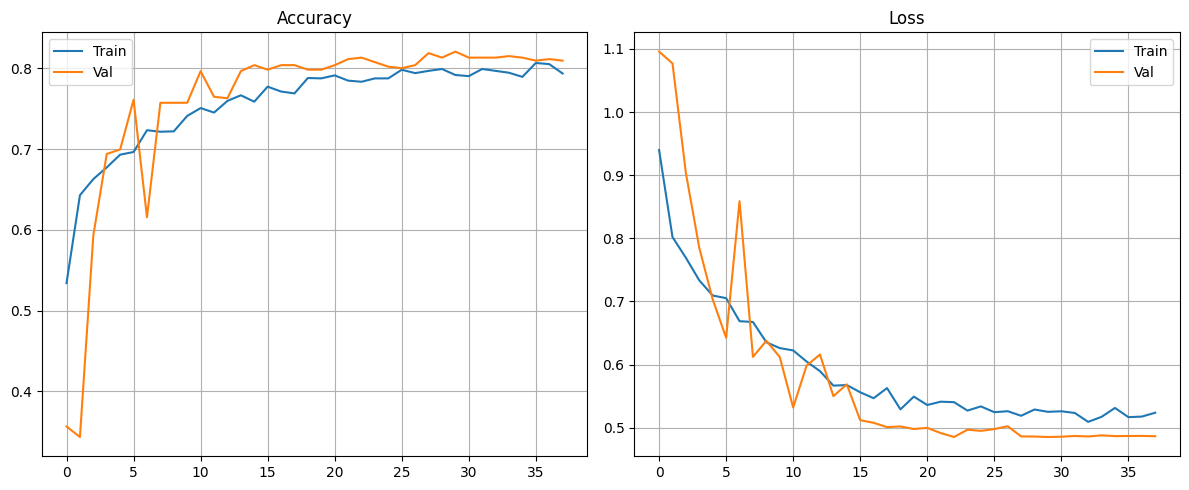

In [8]:
# =========================================================
# TRAINING CURVES
# =========================================================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


📊 Evaluating on SELF-COLLECTED dataset...
Test Accuracy: 40.90%
Test Precision: 45.40%
Test Recall: 29.64%
Test F1-score: 35.87%
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step

📋 Classification Report
              precision    recall  f1-score   support

   aluminium       0.61      0.32      0.42       148
       paper       0.31      0.40      0.35       151
     plastic       0.42      0.47      0.44       234

    accuracy                           0.41       533
   macro avg       0.45      0.40      0.40       533
weighted avg       0.44      0.41      0.41       533



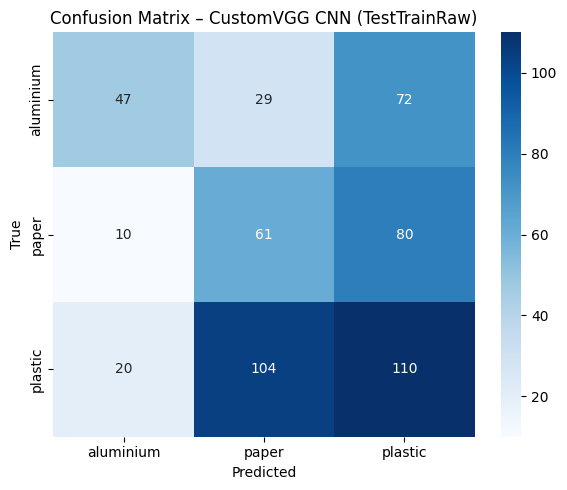

✓ Results logged: CustomVGG_CNN - Raw
  Accuracy: 0.4090, Precision: 0.4540, Recall: 0.2964, F1: 0.3587
✅ Evaluation completed and results logged


In [9]:
# ============================
# EVALUATION ON SELF-COLLECTED DATA
# ============================


print("\n📊 Evaluating on SELF-COLLECTED dataset...")


test_loss, test_acc, test_prec, test_rec = model.evaluate(test_gen, verbose=0)
test_f1 = 2 * (test_prec * test_rec) / (test_prec + test_rec)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Precision: {test_prec*100:.2f}%")
print(f"Test Recall: {test_rec*100:.2f}%")
print(f"Test F1-score: {test_f1*100:.2f}%")


# Predictions
y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_gen.classes


# Classification report
print("\n📋 Classification Report")
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))


# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
xticklabels=test_gen.class_indices.keys(),
yticklabels=test_gen.class_indices.keys())
plt.title('Confusion Matrix – CustomVGG CNN (TestTrainRaw)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Log results to CSV
log_result(
    model_name='CustomVGG_CNN',
    experiment_type='Raw',
    accuracy=test_acc,
    precision=test_prec,
    recall=test_rec,
    f1=test_f1,
    loss=test_loss
)

print("✅ Evaluation completed and results logged")

# =========================================================
# LOAD SAVED MODEL (OPTIONAL)
# =========================================================
If you have already trained the model, load it instead of training again

In [10]:
# Load saved model if it exists
def load_saved_model(model_path):
    """
    Load a saved Keras model
    
    Args:
        model_path: Path to the saved model file
    
    Returns:
        Loaded Keras model or None
    """
    if os.path.exists(model_path):
        print(f"Loading model from {model_path}")
        from tensorflow import keras
        model = keras.models.load_model(model_path)
        print("✓ Model loaded successfully")
        return model
    else:
        print(f"❌ Model not found at {model_path}")
        return None

# Try to load the saved model
model_path = 'models/customvgg_testtrainraw.keras'
loaded_model = load_saved_model(model_path)

if loaded_model is not None:
    print("\n📊 Evaluating loaded model on test set...")
    
    # Recreate test generator
    test_datagen_eval = ImageDataGenerator(rescale=1./255)
    test_gen = test_datagen_eval.flow_from_directory(
        SELF_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False,
        classes=CLASS_NAMES
    )
    
    # Evaluate
    test_loss, test_acc, test_prec, test_rec = loaded_model.evaluate(test_gen, verbose=1)
    test_f1 = 2 * (test_prec * test_rec) / (test_prec + test_rec)
    
    print(f"\nLoaded Model Results:")
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Precision: {test_prec*100:.2f}%")
    print(f"Test Recall: {test_rec*100:.2f}%")
    print(f"Test F1-score: {test_f1*100:.2f}%")
    
    # Log results
    log_result(
        model_name='CustomVGG_CNN',
        experiment_type='Raw',
        accuracy=test_acc,
        precision=test_prec,
        recall=test_rec,
        f1=test_f1,
        loss=test_loss
    )
    
    print("✓ Results logged to final_results.csv")
else:
    print("⚠️ No saved model found. Please train the model first.")


Loading model from models/customvgg_testtrainraw.keras
✓ Model loaded successfully

📊 Evaluating loaded model on test set...
Found 533 images belonging to 3 classes.
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.4090 - loss: 1.4145 - precision: 0.4540 - recall: 0.2964

Loaded Model Results:
Test Accuracy: 40.90%
Test Precision: 45.40%
Test Recall: 29.64%
Test F1-score: 35.87%
✓ Results logged: CustomVGG_CNN - Raw
  Accuracy: 0.4090, Precision: 0.4540, Recall: 0.2964, F1: 0.3587
✓ Results logged to final_results.csv
